In [1]:
# HIDE
%load_ext autoreload
%autoreload 2

In [2]:
# HIDE
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

plt.style.use('default')

%matplotlib inline

In [3]:
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                    'martial_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names,
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex', 'fnlwgt'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

In [4]:
# load ICU data set
X, y, Z = load_ICU_data('../data/adult/adult.data')

n_features = X.shape[1]
n_sensitive = Z.shape[1]

# split into train/test set
(X_train, X_test, y_train, y_test,
 Z_train, Z_test) = train_test_split(X, y, Z, test_size=0.2,
                                     stratify=y)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

features X: 30940 samples, 93 attributes
targets y: (30940,) samples
sensitives Z: 30940 samples, 2 attributes


In [5]:
class PandasDataSet(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()


train_data = PandasDataSet(X_train, y_train, Z_train)
test_data = PandasDataSet(X_test, y_test, Z_test)

In [6]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

# training samples: 24752
# batches: 773


In [7]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=64, p_dropout=0):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [8]:
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

In [9]:
# CHANGE
def pretrain_classifier(clf, data_loader, optimizer, criterion):
    for x, y, _ in data_loader:
        clf.zero_grad()
        p_y = clf(x)
        loss = criterion(p_y, y)
        loss.backward()
        optimizer.step()
    return clf

N_CLF_EPOCHS = 20

for epoch in range(N_CLF_EPOCHS):
    if epoch % 10 == 0:
        print (epoch)
    clf = pretrain_classifier(clf, train_loader, clf_optimizer, clf_criterion)

0
10


In [10]:
# CHANGE

class Adversary(nn.Module):

    def __init__(self, n_sensitive, n_hidden=32):
        super(Adversary, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_sensitive),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))


def pretrain_adversary(adv, clf, data_loader, optimizer, criterion):
    for x, y, z in data_loader:
        p_y = clf(x).detach()
        adv.zero_grad()
        p_z = adv(torch.cat([p_y, y], dim=1))
        loss = (criterion(p_z, z) * lambdas).mean()
        loss.backward()
        optimizer.step()
    return adv


lambdas = torch.Tensor([130, 30])
adv = Adversary(Z_train.shape[1])
adv_criterion = nn.BCELoss(reduce=False)
adv_optimizer = optim.Adam(adv.parameters())

N_ADV_EPOCHS = N_CLF_EPOCHS

for epoch in range(N_ADV_EPOCHS):
    if epoch % 10 == 0:
        print (epoch)
    pretrain_adversary(adv, clf, train_loader, adv_optimizer, adv_criterion)

0
10


In [11]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

def parity(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    return np.abs(y_z_1.mean() - y_z_0.mean())
    
def equality_of_odds(y_true, y_pred, z_values, threshold=0.5):
    y_y_1 = y_pred[y_true == 1]
    y_y_0 = y_pred[y_true == 0]
    
    y_y_1_z_1 = y_y_1[z_values == 1] > threshold if threshold else y_y_1[z_values == 1]
    y_y_1_z_0 = y_y_1[z_values == 0] > threshold if threshold else y_y_1[z_values == 0]
    
    y_y_0_z_1 = y_y_0[z_values == 1] > threshold if threshold else y_y_0[z_values == 1]
    y_y_0_z_0 = y_y_0[z_values == 0] > threshold if threshold else y_y_0[z_values == 0]
    
    tpr_difference = y_y_1_z_1.mean() - y_y_1_z_0.mean()
    fpr_difference = y_y_0_z_1.mean() - y_y_0_z_0.mean()
    return np.abs(tpr_difference), np.abs(fpr_difference)

def _subplot(subplot_df, col, ax):
    for label, df in subplot_df.groupby(col):
        sns.kdeplot(df['y_pred'], ax=ax, label=label, shade=True)
    ax.set_title(f'Income Prediction based on %s' % col)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 7)
    ax.set_yticks([])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Prediction Probability')

def _performance_text(fig, y_test, Z_test, y_pred, Z_pred=None, epoch=None):

    if epoch is not None:
        fig.text(1.0, 1.0, f"Training epoch #{epoch}", fontsize='16')

    clf_roc_auc = metrics.roc_auc_score(y_test, y_pred)
    clf_accuracy = metrics.accuracy_score(y_test, y_pred > 0.5) * 100
    
    p_rules = {'race': p_rule(y_pred, Z_test['race']),
               'sex': p_rule(y_pred, Z_test['sex']),}
    
    parity_rules = {'race': parity(y_pred, Z_test['race']),
               'sex': parity(y_pred, Z_test['sex'])}
        
    eq_rules = {'race': equality_of_odds(y_test, y_pred, Z_test['race']),
               'sex': equality_of_odds(y_test, y_pred, Z_test['sex'])}
    
    fig.text(1.0, 0.8, '\n'.join(["Classifier performance:",
                                   f"- ROC AUC: {clf_roc_auc:.2f}",
                                   f"- Accuracy: {clf_accuracy:.1f}"]),
             fontsize='16')
    fig.text(1.0, 0.6, '\n'.join(["Satisfied p%-rules:"] +
                                 [f"- {attr}: {p_rules[attr]:.1f}%-rule"
                                  for attr in p_rules.keys()]),
             fontsize='16')
    
    fig.text(1.0, 0.4, '\n'.join(["Parity Difference:"] +
                                 [f"- {attr}: {parity_rules[attr]:.3f}"
                                  for attr in parity_rules.keys()]),
             fontsize='16')
    
    fig.text(1.0, 0.2, '\n'.join(["Equality of Odds Difference:"] +
                                 [f"- {attr}: TPR Delta is {eq_rules[attr][0]:.3f}, FPR Delta is {eq_rules[attr][1]:.3f}%"
                                  for attr in eq_rules.keys()]),
             fontsize='16')
    if Z_pred is not None:
        adv_roc_auc = metrics.roc_auc_score(Z_test, Z_pred)
        fig.text(1.0, 0.05, '\n'.join(["Adversary performance:",
                                       f"- ROC AUC: {adv_roc_auc:.2f}"]),
                 fontsize='16')

def plot_distributions(y_true, Z_true, y_pred, Z_pred=None, epoch=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    subplot_df = (
        Z_true
        .assign(race=lambda x: x['race'].map({1: 'Caucasian', 0: 'African-American'}))
        .assign(sex=lambda x: x['sex'].map({1: 'Male', 0: 'Female30'}))
        .assign(y_pred=y_pred)
    )
    _subplot(subplot_df, 'race', ax=axes[0])
    _subplot(subplot_df, 'sex', ax=axes[1])
    _performance_text(fig, y_true, Z_true, y_pred, Z_pred, epoch)
    fig.tight_layout()
    return fig


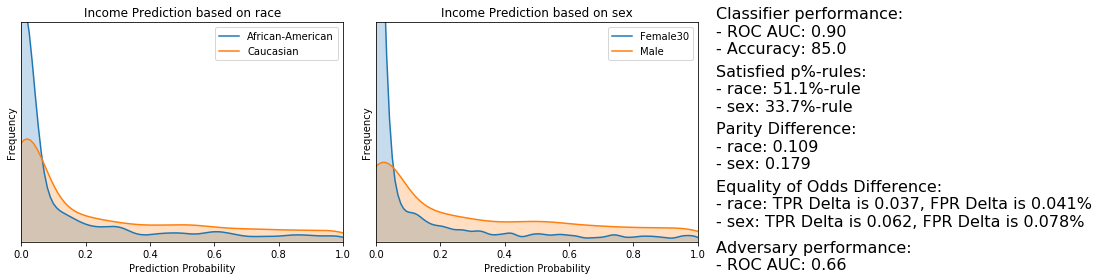

In [12]:
# HIDE

with torch.no_grad():
    pre_clf_test = clf(test_data.tensors[0])
    pre_adv_test = adv(torch.cat([pre_clf_test, test_data.tensors[1]], dim=1))


y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                      index=y_test.index)
y_pre_adv = pd.DataFrame(pre_adv_test.numpy(), columns=Z.columns)
fig = plot_distributions(y_test, Z_test, y_pre_clf, y_pre_adv)
fig.savefig('images/torch_biased_training.png')

In [13]:
# HIDE
!rm -f output/torch_*.png

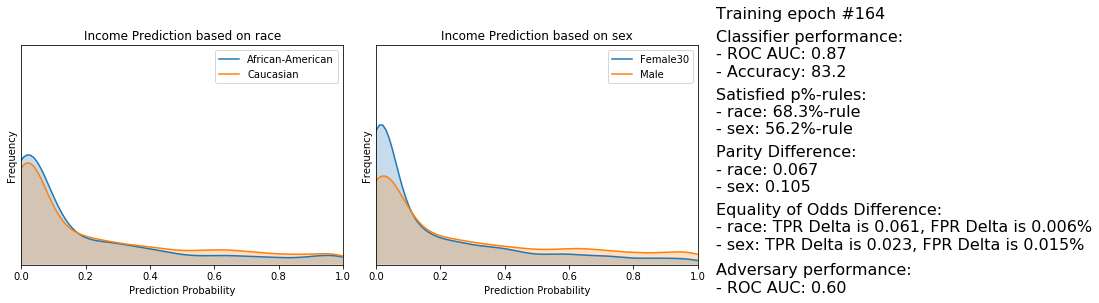

In [14]:
# CHANGE

def train(clf, adv, data_loader, clf_criterion, adv_criterion,
          clf_optimizer, adv_optimizer, lambdas):
    
    # Train adversary
    for x, y, z in data_loader:
        p_y = clf(x)
        adv.zero_grad()
        p_z = adv(torch.cat([p_y, y], dim=1))
        loss_adv = (adv_criterion(p_z, z) * lambdas).mean()
        loss_adv.backward()
        adv_optimizer.step()
 
    # Train classifier on single batch
    for x, y, z in data_loader:
        pass
    p_y = clf(x)
    p_z = adv(torch.cat([p_y, y], dim=1))
    clf.zero_grad()
    p_z = adv(torch.cat([p_y, y], dim=1))
    loss_adv = (adv_criterion(p_z, z) * lambdas).mean()
    clf_loss = clf_criterion(p_y, y) - (adv_criterion(adv(torch.cat([p_y, y], dim=1)), z) * lambdas).mean()
    clf_loss.backward()
    clf_optimizer.step()
    
    return clf, adv

N_EPOCH_COMBINED = 165

for epoch in range(1, N_EPOCH_COMBINED):
    
    clf, adv = train(clf, adv, train_loader, clf_criterion, adv_criterion,
                     clf_optimizer, adv_optimizer, lambdas)

    with torch.no_grad():
        clf_pred = clf(test_data.tensors[0])
        adv_pred = adv(torch.cat([clf_pred, test_data.tensors[1]], dim=1))

    y_post_clf = pd.Series(clf_pred.numpy().ravel(), index=y_test.index)
    Z_post_adv = pd.DataFrame(adv_pred.numpy(), columns=Z_test.columns)
    
    fig = plot_distributions(y_test, Z_test, y_post_clf, Z_post_adv, epoch)
    display.clear_output(wait=True)
    plt.savefig(f'output/torch_{epoch+1:08d}.png', bbox_inches='tight')
    plt.show(plt.gcf())
    
last_img = f'output/torch_{epoch+1:08d}.png'

In [15]:
# HIDE
!convert -loop 0 -delay 0 output/torch_*.png -delay 500 {last_img} images/torch_training.gif